# KNN and DTree [P. Zimmerman]

## Import packages and define utility functions

In [1]:
import pandas as pd
import numpy as np
## plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
## Sklearn libraries
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def model_eval(yt,ypt, yT,ypT):
    return pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(yt, ypt),
                                         precision_score(yt, ypt),
                                         recall_score(yt, ypt)],
                               'Test': [accuracy_score(yT, ypT),
                                        precision_score(yT, ypT),
                                        recall_score(yT, ypT)]})

In [3]:
def fill_nans_with_means(df,col):
    ''' fills nans in column with mean '''
    return df[col].fillna(df[col].mean()).round()

In [4]:
from skimpy import clean_columns
from nltk.metrics import edit_distance

class Cleaner:
    def __init__(self, df):

        self.cdf = clean_columns(df,case='snake')
        self.numerics_df =  self.cdf.select_dtypes(include=[np.number])
        self.numeric_cols = self.numerics_df.columns.values
        self.cats_df =   self.cdf.select_dtypes(include=object)
        self.cat_cols = self.cats_df.columns.values

    def drop_dups(self):
        df = self.cdf
        df_dedupped = df.drop_duplicates()
        # there were duplicate rows
        print('Dropping {} duplicates'.format(df.shape[0] - df_dedupped.shape[0]))
        df = df_dedupped

    def drop_select_dups(self, keys):
        #df.fillna(-999).groupby(keys)['id'].count().sort_values(ascending=False).head(20)
        self.cdf = self.cdf.drop_duplicates(subset=keys)

    def show_missing(self):
        for col in self.cdf.columns:
            pct_missing = np.mean(self.cdf[col].isnull())
            print('{} - {}%'.format(col, round(pct_missing*100)))

    def drop_missing(self, replace=False):
        df = self.cdf
        # first create missing indicator for features with missing data
        for col in df.columns:
            missing = df[col].isnull()
            num_missing = np.sum(missing)
            if num_missing > 0:
                print('created missing indicator for: {}'.format(col))
                df['{}_ismissing'.format(col)] = missing

            if replace == True:
                # categorical
                if col in set(self.numeric_cols):
                    print('Numerical column '+col+' has missing values.')
                    filler = input('Input a filler value (e.g. -999).')
                    df[col] = df[col].fillna(filler).astype(int)
                else:
                    print('Categorical column '+col+' has missing values.')
                    filler = input('Input a filler value (e.g. _MISSING_). ')
                    df[col] = df[col].fillna(filler)

        if replace == False:
            from math import ceil
            cut_off = ceil(0.50*len(df.columns)) # if a row is missing more than 10% of its entries drop it
            ismissing_cols = [col for col in df.columns if 'ismissing' in col]
            df['num_missing'] = df[ismissing_cols].sum(axis=1)
            # drop rows with a lot of missing values.
            ind_missing = df[df['num_missing'] > cut_off].index
            df = df.drop(ind_missing, axis=0)

    def impute_numerics(self):
        df = self.cdf
        for col in self.numeric_cols:
            missing = df[col].isnull()
            num_missing = np.sum(missing)

            if num_missing > 0:  # only do the imputation for the columns that have missing values.
                print('imputing missing values for: {}'.format(col))
                #df['{}_ismissing'.format(col)] = missing
                med = df[col].median()
                df[col] = df[col].fillna(med)

    def impute_cats(self):
        df = self.cdf
        for col in self.cat_cols:
            missing = df[col].isnull()
            num_missing = np.sum(missing)

            if num_missing > 0:  # only do the imputation for the columns that have missing values.
                print('imputing missing values for: {}'.format(col))
                #df['{}_ismissing'.format(col)] = missing
                top = df[col].describe()['top'] # impute with the most frequent value.
                df[col] = df[col].fillna(top)

    def redundants(self):
        df = self.cdf
        num_rows = len(df.index)
        low_information_cols = [] #

        for col in df.columns:
            cnts = df[col].value_counts(dropna=False)
            top_pct = (cnts/num_rows).iloc[0]

            if top_pct > 0.95:
                low_information_cols.append(col)
                print('{0}: {1:.5f}%'.format(col, top_pct*100))
                print(cnts)
                print()


    def col_rename(self, dict_rules):
        ''' rename columns in data frame using a dictionary of rules  '''
        if isinstance(dict_rules,dict):
            self.cdf.rename(columns = dict_rules, inplace=True)
        else:
            raise TypeError

    def expand_timestamp(self, time_colname):
        df = self.cdf
        df['timestamp_dt'] = pd.to_datetime(df[time_colname], format='%Y-%m-%d')
        df['year'] = df['timestamp_dt'].dt.year
        df['month'] = df['timestamp_dt'].dt.month
        df['weekday'] = df['timestamp_dt'].dt.weekday

        print(df['year'].value_counts(dropna=False))
        print()
        print(df['month'].value_counts(dropna=False))

    def get_typos(self,colname, word):
        tmp = pd.DataFrame([])
        tmp[colname] = self.cdf[colname]
        cn = 'distance_'+word
        tmp[cn] = self.cdf[colname].map(lambda x: edit_distance(x, word))
        return tmp.value_counts()

    def fix_typos(self,colname, word, dist=2):
        tmp = self.cdf.copy()
        tmp[colname] = self.cdf[colname]
        cn = 'distance_'+word
        tmp[cn] = self.cdf[colname].map(lambda x: edit_distance(x, word))
        msk = tmp[cn] <= dist
        self.cdf.loc[msk, colname] = word

    def row_string_replace(self, colname, replacement_dict):
        self.cdf[colname] = self.cdf[colname].replace(replacement_dict)



## Read and clean data

In [5]:
TT_SPLIT = 0.30
RAND_STATE = 43

In [6]:
churnData = pd.read_csv('DATA_Customer-Churn.csv') # import data frame

In [7]:
churnData.dtypes  # explore data types

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

TotalCharges should be a float. Notice that it also has empty string values.

In [8]:
# there are empty values, however. For example
churnData['TotalCharges'].loc[488]

' '

In [9]:
# convert to float (nan)
churnData.TotalCharges = pd.to_numeric(churnData.TotalCharges, errors='coerce').astype('float64')
churnData.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [10]:
churnData.isnull().any()  # check for null values

gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
MonthlyCharges      False
TotalCharges         True
Churn               False
dtype: bool

In [11]:
churnData.isnull().values.any()

True

In [12]:
clnr = Cleaner(churnData)

14 column names have been cleaned

In [13]:
clnr.cdf

,gender,senior_citizen,partner,dependents,tenure,phone_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.50,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,No,Yes,Yes,Yes,Yes,One year,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,No,Yes,Yes,No,Yes,Yes,One year,103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,Yes,No,No,No,No,No,Month-to-month,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,No,No,No,No,No,No,Month-to-month,74.40,306.60,Yes


In [14]:
clnr.impute_numerics()

imputing missing values for: total_charges


In [15]:
clnr.cdf.isnull().values.any()

False

In [16]:
# feature selection
churnData = clnr.cdf.drop(labels=['gender','partner','dependents','phone_service','online_security','online_backup',\
                              'device_protection', 'contract','tech_support','streaming_tv','streaming_movies'], axis=1) # drop customer label
churnData.columns

Index(['senior_citizen', 'tenure', 'monthly_charges', 'total_charges',
       'churn'],
      dtype='object')

In [17]:
# X,y split
y = churnData.churn
X = churnData.drop(labels=['churn'],axis=1)

In [18]:
y.replace({'No': 0, 'Yes': 1},inplace=True)

In [19]:
y.value_counts()

0    5174
1    1869
Name: churn, dtype: int64

In [20]:
X

,senior_citizen,tenure,monthly_charges,total_charges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,0,2,53.85,108.15
3,0,45,42.30,1840.75
4,0,2,70.70,151.65
...,...,...,...,...
7038,0,24,84.80,1990.50
7039,0,72,103.20,7362.90
7040,0,11,29.60,346.45
7041,1,4,74.40,306.60


In [21]:
pd.crosstab(X['senior_citizen'], y, normalize='index')

churn,0,1
senior_citizen,,
0,0.763938,0.236062
1,0.583187,0.416813


## Test/train split and EDA

In [22]:
# select 30% for training
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TT_SPLIT,random_state=RAND_STATE)

In [23]:
# transform the data to have zero mean and unit variance
std_scaler = StandardScaler().fit(X_train) 
X_test = std_scaler.transform(X_test)

In [24]:
y_test.value_counts()

0    1550
1     563
Name: churn, dtype: int64

In [25]:
train_data = X_train.join(y_train)

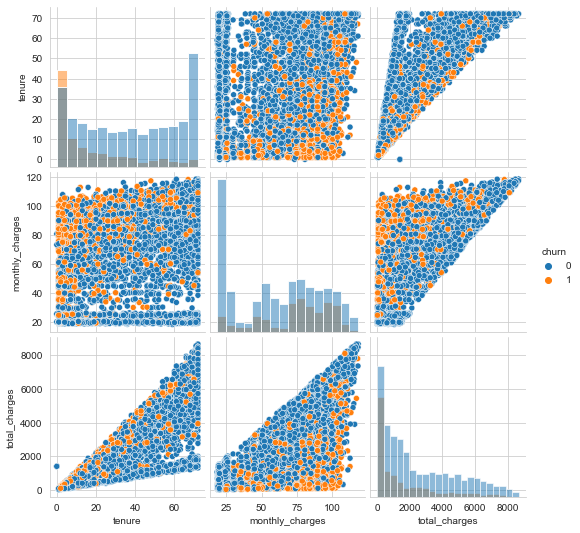

In [26]:
# Pairplots
sns.pairplot(train_data.drop('senior_citizen',axis=1), diag_kind ='hist' , hue="churn")
plt.show()

<AxesSubplot:xlabel='monthly_charges', ylabel='Density'>

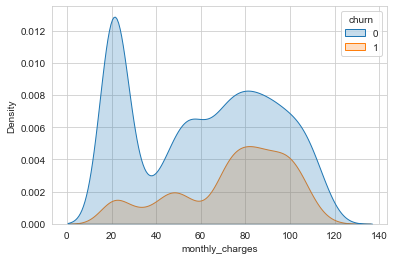

In [27]:
sns.kdeplot(train_data['monthly_charges'], shade=True, shade_lowest=False, hue=train_data['churn'])

<AxesSubplot:xlabel='monthly_charges', ylabel='tenure'>

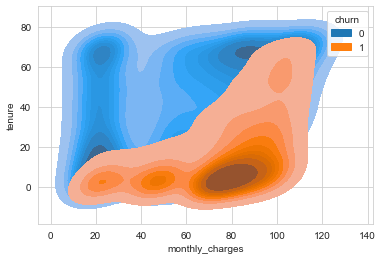

In [28]:
sns.kdeplot(train_data['monthly_charges'],train_data['tenure'], shade=True, shade_lowest=False, hue=train_data['churn'])

<AxesSubplot:ylabel='total_charges'>

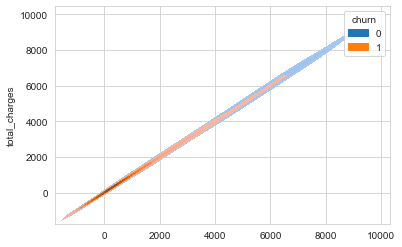

In [29]:
sns.kdeplot(x=train_data['tenure']*train_data['monthly_charges'], y=train_data['total_charges'],
            shade=True, shade_lowest=False, hue=train_data['churn'])

In [30]:
train_data.corr()

,senior_citizen,tenure,monthly_charges,total_charges,churn
senior_citizen,1.000000,0.014334,0.225259,0.104663,0.153105
tenure,0.014334,1.000000,0.243396,0.824112,-0.348953
monthly_charges,0.225259,0.243396,1.000000,0.650318,0.191010
total_charges,0.104663,0.824112,0.650318,1.000000,-0.194058
churn,0.153105,-0.348953,0.191010,-0.194058,1.000000


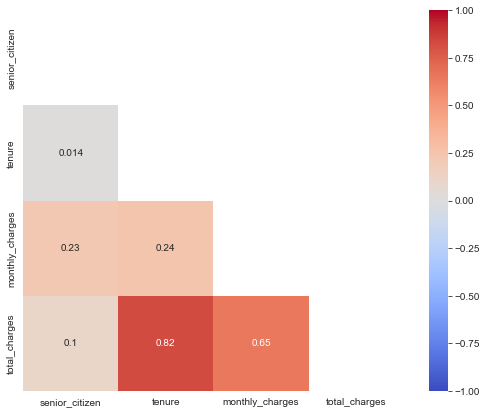

In [31]:
n_corr = X_train.corr()
mask = np.zeros_like(n_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(n_corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

## KNN

In [32]:
N_NEIGHS = 5

In [33]:
# model with KNN using 2 neighbors for clustering
knn = KNeighborsClassifier(n_neighbors=N_NEIGHS, weights='uniform')
knn.fit(X_train, y_train)


y_pred_test = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

In [34]:
model_eval(y_train, y_pred_train, y_test, y_pred_test) # get model errors

,Error_metric,Train,Test
0,Accuracy,0.830020,0.733554
1,Precision,0.736842,0.000000
2,Recall,0.557427,0.000000


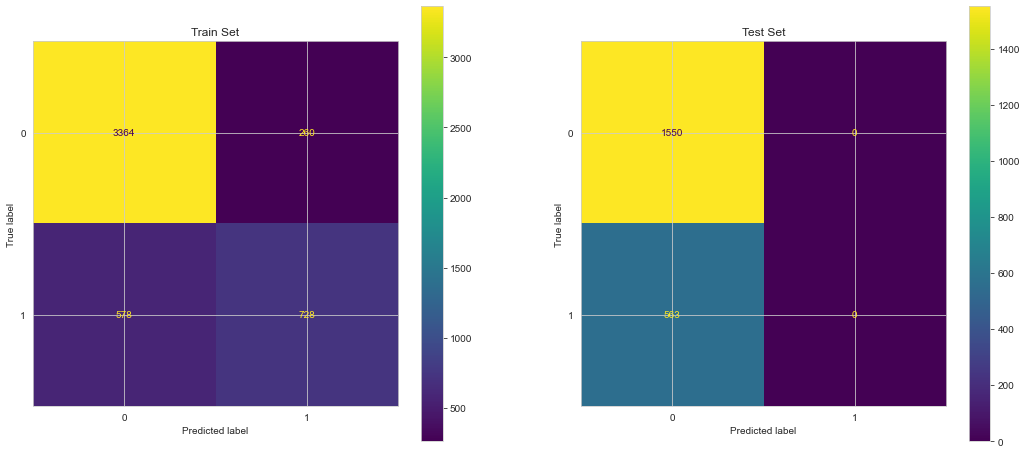

In [35]:
# plot confusion matrix
fig, ax = plt.subplots(1,2, figsize=(18,8))

plot_confusion_matrix(knn,X_train,y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")

plot_confusion_matrix(knn,X_test,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

In [36]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

## Decision Tree

In [37]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TT_SPLIT,random_state=RAND_STATE)

In [38]:
DEPTH = 6
dt = {}
yp_tst = {}
yp_trn = {}
model_eval_dict = {}
for d in range(2,7):
    dt[d] = DecisionTreeClassifier(max_depth=d)
    dt[d] = dt[d].fit(X_train, y_train)
    yp_tst[d] = dt[d].predict(X_test)
    yp_trn[d] = dt[d].predict(X_train)
    model_eval_dict[d] = model_eval(y_train, yp_trn[d], y_test, yp_tst[d])

dt6 = DecisionTreeClassifier(max_depth=DEPTH)

dt6.fit(X_train, y_train)

y_pred_train_dt = dt6.predict(X_train)
y_pred_test_dt  = dt6.predict(X_test)

In [39]:
model_eval(y_train, y_pred_train_dt, y_test, y_pred_test_dt) # get model errors

,Error_metric,Train,Test
0,Accuracy,0.805477,0.770942
1,Precision,0.655885,0.580122
2,Recall,0.558959,0.507993


In [40]:
[model_eval_dict[d].Test.iloc[0] for d in model_eval_dict.keys()]

[0.780407004259347,
 0.780407004259347,
 0.779460482725982,
 0.783719829626124,
 0.7699952673923331]

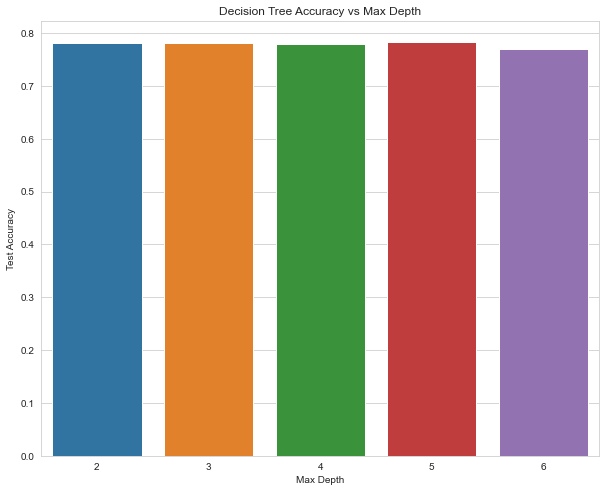

In [41]:
f,ax = plt.subplots(figsize=(10,8))
ax.set_xlabel('Max Depth')
ax.set_ylabel('Test Accuracy')
ax.set_title('Decision Tree Accuracy vs Max Depth')
_=sns.barplot(x=list(model_eval_dict.keys()), y=[model_eval_dict[d].Test.iloc[0] for d in model_eval_dict.keys()])

In [42]:
dt=dt6

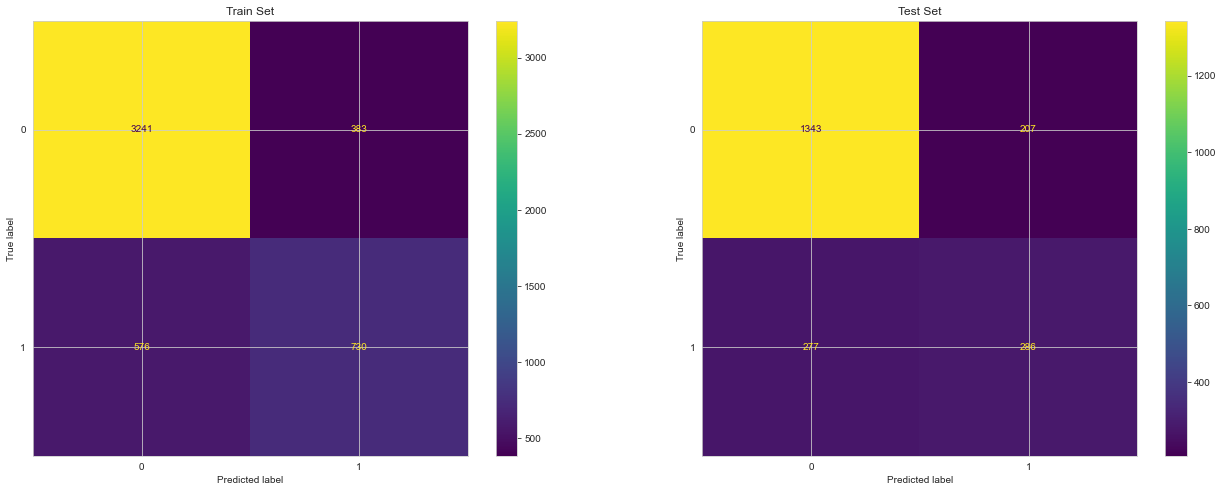

In [43]:
# confusion matrix
fig, ax = plt.subplots(1,2, figsize=(22,8))
plot_confusion_matrix(dt,X_train,y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")
plot_confusion_matrix(dt,X_test,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

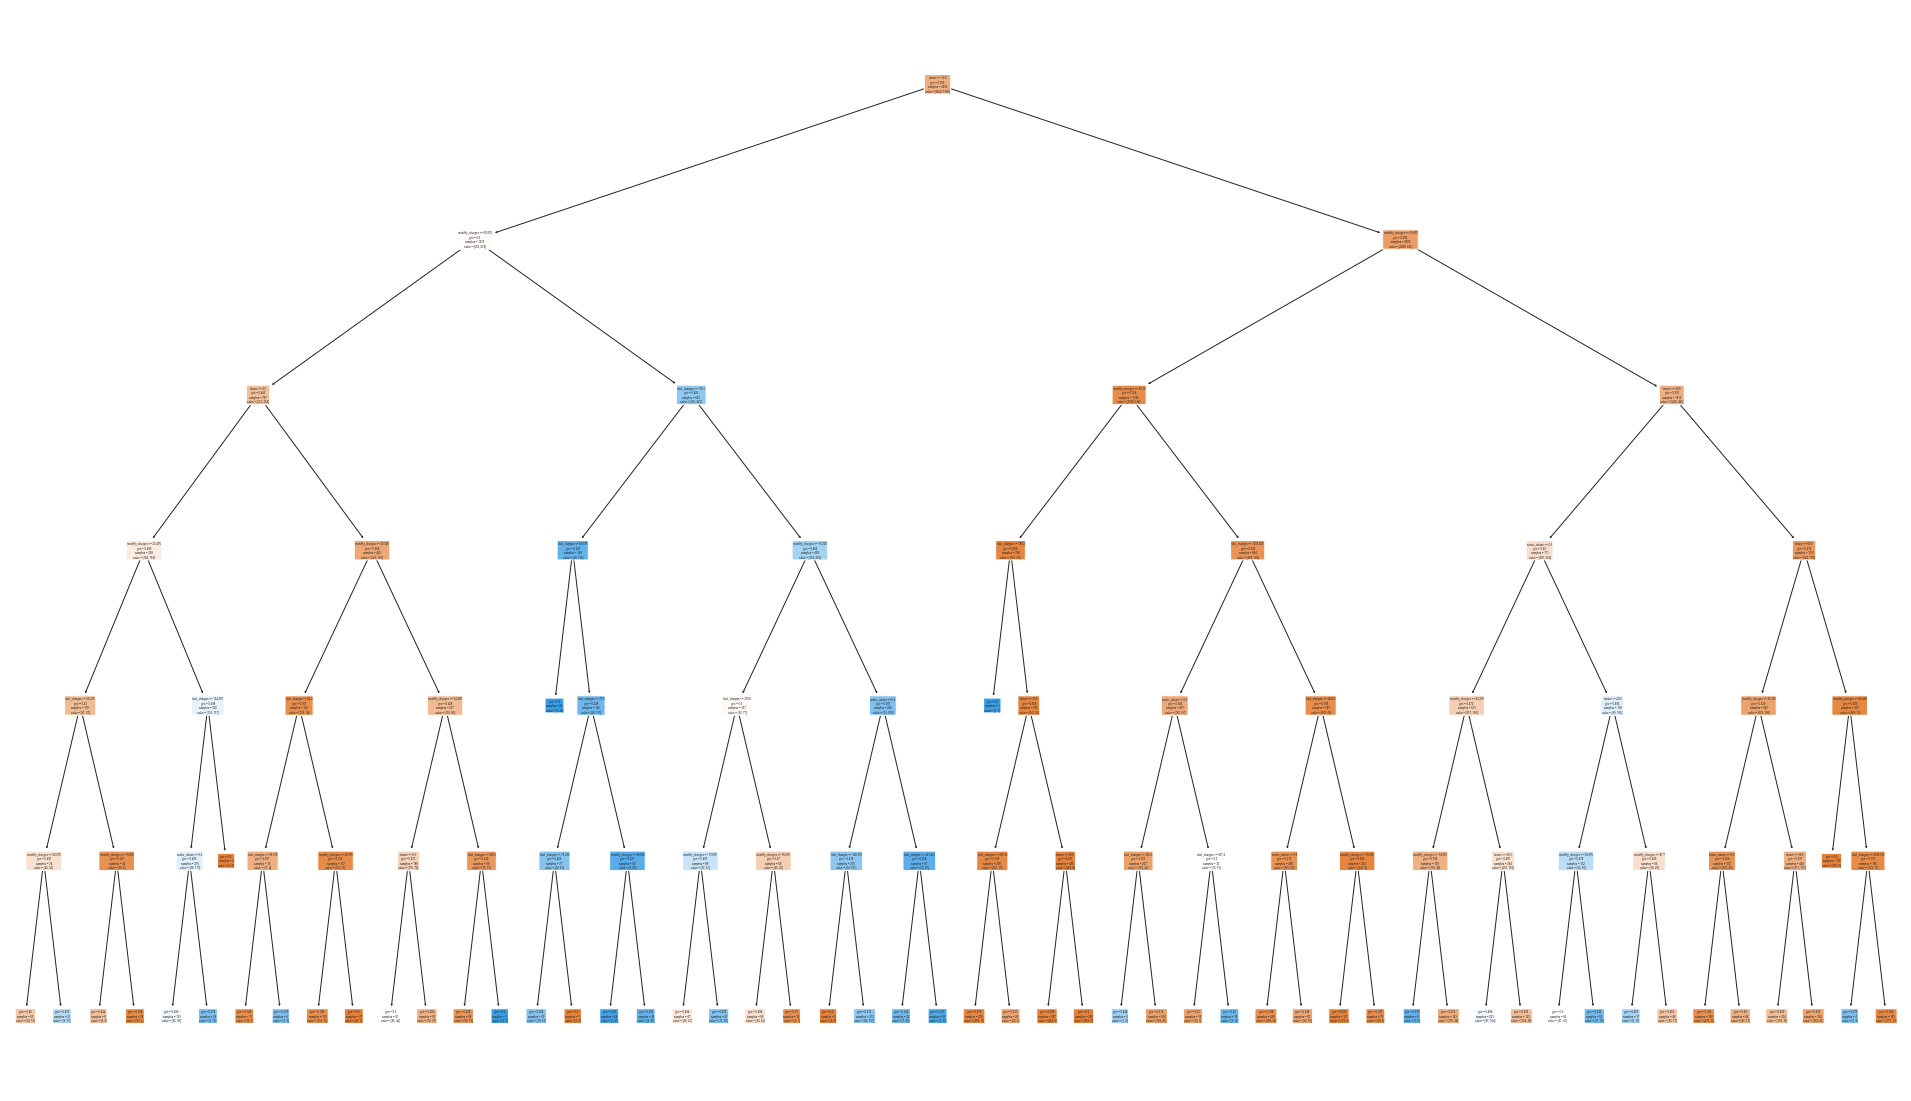

In [44]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (34,20))

plot_tree(dt,filled = True, rounded=True,feature_names=X.columns)
plt.show()

In [45]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}